## Excel Compiler Code
##### By Julian Thong Joon Yip

In [2]:
import pandas as pd
import os

# Define the folder and file names
folder_name = 'Customer Excel Compiler'
file_name = 'Customer Data.xlsx'

# Construct the file path dynamically
file_path = os.path.join(os.path.expanduser('~'), 'Desktop', folder_name, file_name)

# Check if the file exists
if not os.path.exists(file_path):
    print(f"The file {file_path} does not exist.")
else:
    # Load the Excel file with specifying the dtype for GTIN column to avoid scientific notation
    excel_file = pd.ExcelFile(file_path)
    excel_dtypes = {'GTIN': str}  # Specify dtype as string to avoid scientific notation

    # Filter out the sheet named "Data Table"
    sheet_names = [sheet_name for sheet_name in excel_file.sheet_names if sheet_name != 'Date Table']

    # Read data from remaining sheets
    df_dict = pd.read_excel(excel_file, sheet_name=sheet_names, dtype=excel_dtypes)

    # Initialize an empty list to store DataFrames
    data_frames = []

    # Loop through each sheet in the Excel file
    for sheet_name, df in df_dict.items():
        # Add a column for the sheet name
        df['SheetName'] = sheet_name

        # Convert the DataFrame from wide format to long format
        df_long = df.melt(id_vars=['SubCategoryName', 'BaseProductName', 'Material', 'MaterialName', 'GTIN', 'SheetName'],
                          var_name='YearMonth',
                          value_name='Value')

        # Append the long format DataFrame to the list
        data_frames.append(df_long)

    # Check if there are any DataFrames to concatenate
    if data_frames:
        # Concatenate all DataFrames in the list into one master DataFrame
        master_df = pd.concat(data_frames, ignore_index=True)

        # Specify the output path for the master file
        output_file_path = os.path.join(os.path.expanduser('~'), 'Desktop', folder_name, 'master_file.xlsx')

        # Check if the output file already exists
        if os.path.exists(output_file_path):
            os.remove(output_file_path)  # Delete the file if it exists

        # Export the master DataFrame to a new Excel file
        master_df.to_excel(output_file_path, index=False)

        print(f"Master file created at: {output_file_path}")
    else:
        print("No valid data found to compile.")


Master file created at: C:\Users\MYThongJJu\Desktop\Customer Excel Compiler\master_file.xlsx


In [5]:
import pandas as pd
import os
import math

# Define the folder and file names
folder_name = 'Customer Excel Compiler'
file_name = 'Customer Data.xlsx'

# Construct the file path dynamically
file_path = os.path.join(os.path.expanduser('~'), 'Desktop', folder_name, file_name)
output_file_path = os.path.join(os.path.expanduser('~'), 'Desktop', folder_name, 'master_file.xlsx')

# Read the "Date Table" sheet from the original Excel file
date_table = pd.read_excel(file_path, sheet_name='Date Table')

# Calculate summary data
summary_data = master_df.groupby(['GTIN', 'YearMonth']).agg({'Value': 'sum'}).reset_index()
summary_data['YearMonth'] = summary_data['YearMonth'].astype(str)  # Convert YearMonth to string

# Merge summary_data with date_table based on YearMonth
summary_data = summary_data.merge(date_table[['YearMonth', 'WeekNo']], on='YearMonth', how='left')

# Calculate forecast_qty
summary_data['forecast_qty'] = summary_data['Value'] / summary_data['WeekNo']
summary_data['forecast_qty'] = summary_data['forecast_qty'].apply(lambda x: math.ceil(x))  # Round up to the nearest integer

# Rename columns
summary_data.rename(columns={'GTIN': 'product_code', 'Value': 'total_value'}, inplace=True)

# Create a new Excel writer object
with pd.ExcelWriter(output_file_path, engine='openpyxl', mode='a') as writer:
    if 'summary' in pd.ExcelFile(output_file_path).sheet_names:
        # Remove existing 'summary' sheet
        writer.book.remove(writer.book['summary'])

    # Write the summary data to a new sheet
    summary_data.to_excel(writer, sheet_name='summary', index=False)

# Check if the summary sheet was successfully added or replaced
if 'summary' in pd.ExcelFile(output_file_path).sheet_names:
    print("Summary sheet added/replaced successfully.")
else:
    print("Failed to add/replace the summary sheet.")


Summary sheet added/replaced successfully.


#### Code to create "Summary Year-Week" sheet in master_file
- product_code : Taken from GTIN in summary sheet
- year_month_week: Added number of weeks for each Year_Month based on the "Customer Data" Date Table Sheet
- year_week: Combination of the Year and Week in format (yyyymm)
- forecast_qty: Taken from summary sheet and duplicated for each product_code in a given year_month

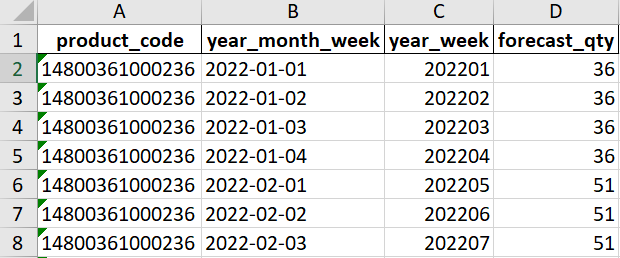

In [6]:
import pandas as pd

# Define the folder and file names
folder_name = 'Customer Excel Compiler'
file_name = 'Customer Data.xlsx'

# Construct the file path dynamically
file_path = os.path.join(os.path.expanduser('~'), 'Desktop', folder_name, file_name)
output_file_path = os.path.join(os.path.expanduser('~'), 'Desktop', folder_name, 'master_file.xlsx')

# Specify the paths to your Excel files
file_path_master = os.path.join(os.path.expanduser('~'), 'Desktop', folder_name, 'master_file.xlsx')

# Read the 'summary' sheet from the Excel file
summary_df = pd.read_excel(file_path_master, sheet_name='summary')

# Read the 'Date Table' sheet from the Customer file
date_table_df = pd.read_excel(file_path, sheet_name='Date Table')

# Merge the summary_df with date_table_df on 'YearMonth' to add 'WeekOffset' column
expanded_summary_df = summary_df.merge(date_table_df[['YearMonth', 'WeekOffset']], on='YearMonth', how='left')

# Create an empty list to store the expanded summary data
expanded_summary_data = []

# Iterate through each row in the summary DataFrame
for _, row in expanded_summary_df.iterrows():
    # Format product_code to match GTIN format (leading zeros)
    product_code = str(row['product_code']).zfill(14)
    year_month = row['YearMonth']
    week_no = row['WeekNo']
    forecast_qty = row['forecast_qty']
    week_offset = row['WeekOffset']
    
    # Create new rows for each week based on the 'WeekNo' value
    for week in range(1, week_no + 1):
        year_month_week = f"{year_month}-{str(week).zfill(2)}"  # Combine YearMonth and week number
        # Calculate year_week by adding WeekOffset to the week number
        year_week = int(f"{year_month.split('-')[0]}{week + week_offset:02}")  # Year + week
        expanded_summary_data.append({'product_code': product_code, 'year_month_week': year_month_week, 'year_week': year_week, 'forecast_qty': forecast_qty})

# Create a new DataFrame from the expanded summary data
expanded_summary_df = pd.DataFrame(expanded_summary_data)

# Create a new Excel writer object
with pd.ExcelWriter(output_file_path, engine='openpyxl', mode='a') as writer:
    # Replace the existing 'Summary Year-Week' sheet with the new one
    if 'Summary Year-Week' in pd.ExcelFile(output_file_path).sheet_names:
        writer.book.remove(writer.book['Summary Year-Week'])
    
    # Write the expanded summary data to a new sheet
    expanded_summary_df.to_excel(writer, sheet_name='Summary Year-Week', index=False)

print("Summary Year-Week sheet created successfully.")


Summary Year-Week sheet created successfully.


## Below is testing code

In [10]:
import pandas as pd

# Specify the path to your Excel file
file_path = r'C:\Users\MYThongJJu\Desktop\Personal\Working Files (Local)\Kenneth AEON BIG baseline project\master_file.xlsx'
output_file_path = r'C:\Users\MYThongJJu\Desktop\Personal\Working Files (Local)\Kenneth AEON BIG baseline project\master_file.xlsx'

# Read the 'summary' sheet from the Excel file
summary_df = pd.read_excel(file_path, sheet_name='summary')

# Create an empty list to store the expanded summary data
expanded_summary_data = []

# Iterate through each row in the summary DataFrame
for _, row in summary_df.iterrows():
    # Format product_code to match GTIN format (leading zeros)
    product_code = str(row['product_code']).zfill(14)
    year_month = row['YearMonth']
    week_no = row['WeekNo']
    forecast_qty = row['forecast_qty']
    
    # Create new rows for each week based on the 'WeekNo' value
    for week in range(1, week_no + 1):
        year_month_week = f"{year_month}-{str(week).zfill(2)}"  # Combine YearMonth and week number
        expanded_summary_data.append({'product_code': product_code, 'year_month_week': year_month_week, 'forecast_qty': forecast_qty})

# Create a new DataFrame from the expanded summary data
expanded_summary_df = pd.DataFrame(expanded_summary_data)

# Create a new Excel writer object
with pd.ExcelWriter(output_file_path, engine='openpyxl', mode='a') as writer:
    # Replace the existing 'Summary Year-Week' sheet with the new one
    if 'Summary Year-Week' in pd.ExcelFile(output_file_path).sheet_names:
        writer.book.remove(writer.book['Summary Year-Week'])
    
    # Write the expanded summary data to a new sheet
    expanded_summary_df.to_excel(writer, sheet_name='Summary Year-Week', index=False)

print("Summary Year-Week sheet created successfully.")


Summary Year-Week sheet created successfully.


In [20]:
import calendar

def num_weeks_in_month(year, month):
    """
    Calculate the number of weeks in a given month and year.
    
    Args:
    - year (int): The year.
    - month (int): The month (1-12).
    
    Returns:
    - num_weeks (int): The number of weeks in the month.
    """
    num_weeks = len(calendar.monthcalendar(year, month))
    return num_weeks

# Example usage:
year = 2022
month = 1
weeks_in_month = num_weeks_in_month(year, month)
print(f"Number of weeks in {calendar.month_name[month]} {year}: {weeks_in_month}")


Number of weeks in January 2022: 6


In [64]:
import calendar
from datetime import date, timedelta

def count_full_weeks(year):
    month_full_weeks = {}
    
    for month in range(1, 13):
        # Find the first day of the month and the total number of days in the month
        first_day_of_month = date(year, month, 1)
        num_days_in_month = calendar.monthrange(year, month)[1]
        last_day_of_month = date(year, month, num_days_in_month)
        
        # Initialize counter for full weeks
        full_weeks = 0
        
        # Start from the first day of the month
        current_day = first_day_of_month
        
        # Iterate through the days of the month
        while current_day <= last_day_of_month:
            # Check if the current day is a Monday
            if current_day.weekday() == 0:  # 0 = Monday, 1 = Tuesday, ..., 6 = Sunday
                # Check if this week's Friday is within the same month
                friday_of_week = current_day + timedelta(days=4)
                if friday_of_week <= last_day_of_month:
                    full_weeks += 1
                else:
                    # If Friday is not in the same month, count this week for the next month
                    if month < 12:  # If not December
                        next_month = month + 1
                    else:
                        next_month = 1  # Wrap around to January
                        year += 1  # Increment the year

                    if next_month not in month_full_weeks:
                        month_full_weeks[next_month] = 0
                    
                    month_full_weeks[next_month] += 1
                    break
            # Move to the next day
            current_day += timedelta(days=1)
        
        if month not in month_full_weeks:
            month_full_weeks[month] = full_weeks
        else:
            month_full_weeks[month] += full_weeks
    
    return month_full_weeks

# Print the number of full Monday to Friday weeks in each month of the year 2024
year = 2024
month_full_weeks = count_full_weeks(year)
for month, weeks in sorted(month_full_weeks.items()):
    print(f"{year}-{month:02}: {weeks} full Monday to Friday weeks")


2024-01: 5 full Monday to Friday weeks
2024-02: 4 full Monday to Friday weeks
2024-03: 5 full Monday to Friday weeks
2024-04: 4 full Monday to Friday weeks
2024-05: 5 full Monday to Friday weeks
2024-06: 4 full Monday to Friday weeks
2024-07: 4 full Monday to Friday weeks
2024-08: 5 full Monday to Friday weeks
2024-09: 4 full Monday to Friday weeks
2024-10: 4 full Monday to Friday weeks
2024-11: 5 full Monday to Friday weeks
2024-12: 4 full Monday to Friday weeks


In [62]:
import calendar

def count_fridays_in_month(year, month):
    # Get the number of days in the month
    num_days_in_month = calendar.monthrange(year, month)[1]
    
    # Initialize a counter for Fridays
    num_fridays = 0
    
    # Iterate through each day of the month
    for day in range(1, num_days_in_month + 1):
        # Check if the day is a Friday (weekday() returns 4 for Friday)
        if calendar.weekday(year, month, day) == 4:
            num_fridays += 1
    
    return num_fridays

# Print the number of Fridays in each month of the year 2024
year = 2024
for month in range(1, 13):
    num_fridays = count_fridays_in_month(year, month)
    print(f"{year}-{month:02}: {num_fridays} Fridays")


2024-01: 4 Fridays
2024-02: 4 Fridays
2024-03: 5 Fridays
2024-04: 4 Fridays
2024-05: 5 Fridays
2024-06: 4 Fridays
2024-07: 4 Fridays
2024-08: 5 Fridays
2024-09: 4 Fridays
2024-10: 4 Fridays
2024-11: 5 Fridays
2024-12: 4 Fridays


Summary Year-Week sheet created successfully.
